In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import open
import string
from IPython.display import clear_output

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

nn.Conv2d(,)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
from IPython.display import clear_output
#Import clear_output basically, in case when want continous output from a single cell and just want to 
#retain a signle output.

In [ ]:
#data formatting.
nat = []
X = []
Y = []
data = []
i=0
j=0
k=0
with open('name2lang.txt') as l: #Reading data from text_file (line by line).
  for f in l:
    text = l.readline()
    text = text.split(',')
    X.append(text[0])            #Storing names.
    Y.append(text[1].strip())       # storing all languages
    if  text[1].strip()  not in nat:
      nat.append(text[1].strip())
    
    if text[1].strip() == 'Russian':
      i = i + 1
      if i%30 == 0:
        k+=1
        data.append(text)
      else:
        continue
    
    elif text[1].strip() == 'English':
      j+=1
      if j%25 == 0:
        k+=1
        data.append(text)
      else:
        continue
    
    elif text[1].strip() == 'Arabic':
      j+=1
      if j%2 == 0:
        k+=1
        data.append(text)
      else:
        continue

    else:
      data.append(text) 

len_nat = len(nat);
print(i,k,j)

4692 729 2834


In [ ]:
len(data)

3228

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state = 42, stratify  = Y);

In [ ]:
print(X_train[0:4], Y_train[0:4])

['Robert', 'Bosch', 'Price', 'Chekin'] ['Dutch', 'German', 'English', 'Russian']


#Encoding the given dataset.

In [ ]:
all_letters = string.ascii_letters + ',.;:'
ll = len(all_letters)

In [ ]:
def name_rep(s):
  rep = torch.zeros(len(s),1,ll)  #Created a blank_one_hot_encoder of size (len(letter),0,26);
  for index,charac in enumerate(s): #Gives index, character value of s character.
    pos = all_letters.find(charac) #Return poisition of char in all_letters-->(to one hot encode.)
    rep[index][0][pos] = 1
  return rep

In [ ]:
def  nat_rep(s):
  return torch.tensor([nat.index(s)], dtype = torch.long)

In [ ]:
nat_rep(nat[9])

tensor([9])

In [ ]:
print(name_rep('Akshit'));

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

#Visualization of data!

In [ ]:
#Checking distribution of each language in names.
dis = {}
for i in nat:
  dis[i]=1
for d in data:
  dis[d[1].split()[0]]+=1
print(dis['Russian'])

157


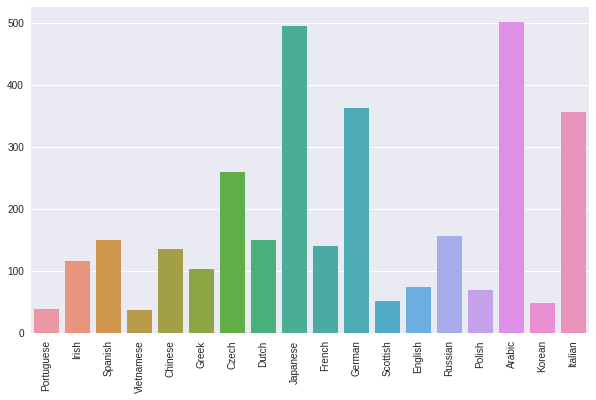

In [ ]:
plt.style.use('seaborn')
fig = plt.gcf()
fig.set_size_inches(10,6);
sns.barplot(x=list(dis.keys()), y =list(dis.values()));
plt.xticks(rotation = 90);
plt.show()

Clearly, the data is distributed very in a very biased way. 
The model is more likely to predict the particular class "Russia", more oftenly.

Model!

In [ ]:
class RNN_net_1(nn.Module):
  
  def __init__(self,hidden_size, input_size, output_size):
    super(RNN_net_1, self).__init__()
    self.hidden = hidden_size
    self.i2h = nn.Linear(hidden_size + input_size, hidden_size) #Conmputing the hidden_layers. The input to any hidden_layer is s_t = s_t-1 + x_t.
    self.i2o = nn.Linear(hidden_size + input_size, output_size)  #Computing the output_layer. In our case, it is end result.
    self.soft = nn.LogSoftmax(dim=1) #Here, using the softmax function for output layer.

  def forward(self, input, hidden):
    comb = torch.cat((input, hidden), 1)
    hidden = self.i2h(comb);                                          #Calculating the hidden layer.
    out_put = self.i2o(comb)                                          #Calculatin the output. As we are doing at each level, we are doing 
                                                                      #seqnce to seq classification.
    out = self.soft(out_put)                                       #Applieng the softmax at the end.

    return out, hidden
  
  def init_hidden(self):
    return torch.zeros(1,self.hidden)

In [ ]:
hidden_layers = 64
net =   RNN_net(hidden_layers, len(all_letters), len(nat))

In [ ]:
nat

['Portuguese',
 'Irish',
 'Spanish',
 'Vietnamese',
 'Chinese',
 'Greek',
 'Czech',
 'Dutch',
 'Japanese',
 'French',
 'German',
 'Scottish',
 'English',
 'Russian',
 'Polish',
 'Arabic',
 'Korean',
 'Italian']



```
RNN_net(
  (i2h): Linear(in_features=184, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=56, bias=True)
  (soft): LogSoftmax(dim=1)
)
```
>single hidden_layer network



In [ ]:
def get_val(net,name):
  net.eval()
  name_one = name_rep(name)                       #One_hot encoding converison of the name.
  hidden = net.init_hidden()                      #Initializing the 0th hidden_layer.
  for i in range(name_one.shape[0]):                                  #Moving character_by_character.
    out, hidden = net.forward(name_one[i], hidden)   #This is a recurrent process, which uses hidden as the recurrent unit.           
   
  return out


In [ ]:
out_put = get_val(net,'Adam')
a = torch.argmax(out_put, dim=1).item()
print(a, nat[a])

2 Spanish


>Creating dataloader

In [ ]:
def dataloader(pts_n, X,Y):
  to_ret = []
  for i in range(pts_n):
    no = np.random.randint(len(X))
    name, nat_ = X[no], Y[no]
    to_ret.append((name, nat_, name_rep(name), nat_rep(nat_)))

  return to_ret

In [ ]:
data = dataloader(10,X,Y)
print(data)

[('Researcher', 'Russian', tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.

In [ ]:
def evaluate(net, n_pts,k, X_, Y_):
  # Top_k accuracy measure:
  net.eval()                                        #EVALUATION_MODE.
  data = dataloader(n_pts, X_, Y_)                  #CHOOSING_POINTS DATA.
  correct = 0
  for name, nat, name_one, nat_r in data:
    out = get_val(net,name)
    values, indeces = out.topk(k)                   #CHECKING FOR TOP K VALUES.

    if nat_r in indeces:
      correct+=1
  
  acc = correct/n_pts
  return acc


In [ ]:
print(evaluate(net, 1000,2,X_test,Y_test))

0.075


>https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method

For retain_graph = True.

In [ ]:
from tqdm.notebook import tqdm_notebook
len(nat)

18

In [ ]:
def fit(net_ ,opt, loss_fn,b_s, n_points):   
  # confusion_matrix[1][2]=1
  k=0
  loss_ = []
  
  for i in tqdm_notebook(range(b_s), total = b_s, unit= 'batch'):
    
    total = 0
    
    data = dataloader(n_points, X_train, Y_train)
    opt.zero_grad()
    
    for name, nat, name_one, nat_r in data:
    
      hidden = net_.init_hidden()
    
      for p in range(name_one.size()[0]):                                  #Moving character_by_character.
        out, hidden = net_.forward(name_one[p], hidden)  
      
      m = torch.argmax(out,axis=1)
      j = nat_r

      k+=1
      confusion_matrix[j][m] +=1 
    
      loss = loss_fn(out, nat_r)
      loss.backward(retain_graph = True)
    
      total += loss
    
    loss_.append( total/n_points )
    opt.step()
  print(k)
  return loss_,k



In [ ]:
# # opt = optim.SGD(net1.parameters(), lr= 0.01, momentum=0.01,weight_decay=0.05)
# # loss = fit(net1 ,opt, loss_fn, 350, 10)

# net1 = RNN_net(64, len(all_letters), len(nat))
# loss_fn = nn.NLLLoss()
# opt = optim.SGD(net1.parameters(), lr= 0.005, momentum=0.01,weight_decay=0.01)
# loss = fit(net1 ,opt, loss_fn, 350, 25)

# print("Loss: {} Accuracy_test: {} Accuracy_train: {}".format(loss[-1],
#       evaluate(net1,10,1,X_test,Y_text), evaluate(net1,10,1,X_train,Y_train)))

# plt.figure()
# plt.plot(loss)
# plt.xlabel('Batchs')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
def train_setup(n,opt_m = 'sgd', batches = 100, batch_size = 25, learning_rate = 0.005, mom = 0.01):
  
# opt = optim.SGD(net1.parameters(), lr= 0.01, momentum=0.01,weight_decay=0.05)
# loss = fit(net1 ,opt, loss_fn, 350, 10)
  loss_fn = nn.NLLLoss()  
  if opt_m =='sgd':
    opt = optim.SGD(n.parameters(), lr = learning_rate, momentum = mom,weight_decay=0.01)
  
  if opt_m == 'Adam':
    opt = optim.Adam(n.parameters(), lr = learning_rate)
  loss,k = fit(n ,opt, loss_fn, batches, batch_size)
  
  print("Loss: {} Accuracy_test: {} Accuracy_train: {}".format(loss[-1],
      evaluate(n,1000,1,X_test,Y_test), evaluate(n,1000,1,X_train,Y_train)))

  plt.figure()
  plt.plot(loss)
  plt.xlabel('Batchs')
  plt.ylabel('Loss')
  plt.show()

  
  
                      


250000
Loss: 0.8094300627708435 Accuracy_test: 0.742 Accuracy_train: 0.751


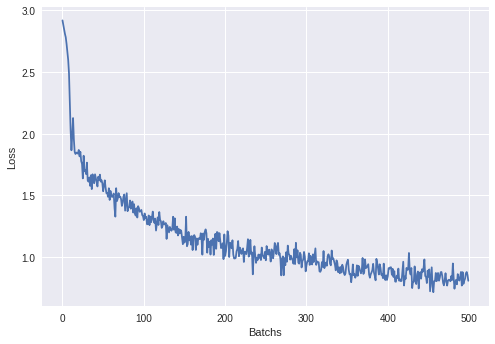

In [ ]:
net1 = RNN_net(64, len(all_letters), len(nat))
confusion_matrix = np.zeros((len(nat) ,len(nat)))
train_setup(net1,'Adam',batches = 500 ,batch_size =500 ,learning_rate = 0.0025 ,mom = 0.05)


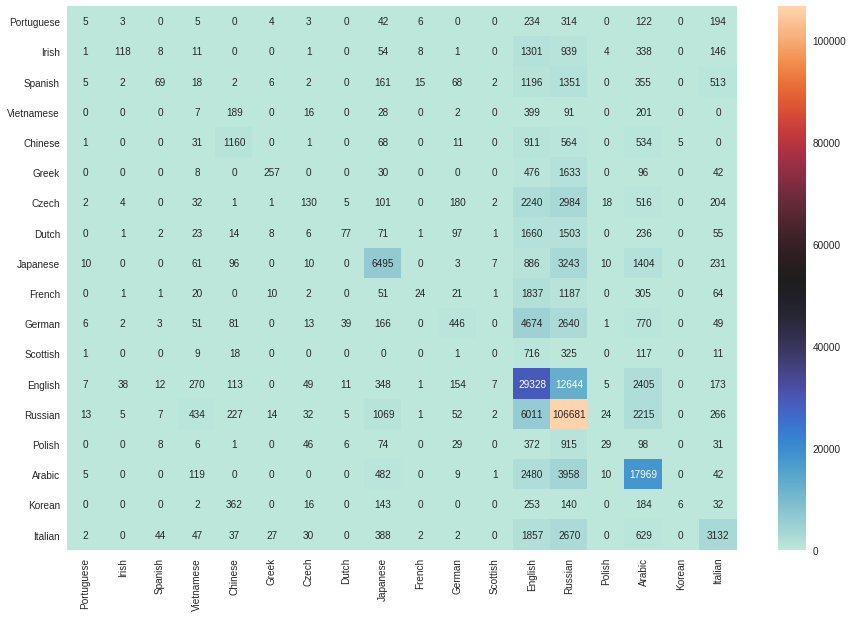

In [ ]:

fig = plt.figure(figsize= (15,10))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f',xticklabels=nat, 
            yticklabels=nat,cmap='icefire');

In [ ]:
total_ = confusion_matrix.sum()
total_

corr_ = 0
for i in range(18):
  for j in range(18):
    if i == j:
      corr_ += confusion_matrix[i][j]
print(corr_)

165933.0


In [ ]:
print(evaluate(net1, 2500,1,X_test, Y_test));
print(evaluate(net1, 2500,1,X_train, Y_train));

0.7444
0.7516


In [ ]:
a = 'Bazzi'  
lan = get_val(net1, a)
nat[torch.argmax(lan, 1)]

'Arabic'

LSTM_Class

In [ ]:
class LSTM_net(nn.Module):
  def __init__(self,hidden_size,input_size, output_size):
    super(LSTM_net,self).__init__()
    self.hidden = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.lstm_cell_2 = nn.LSTM(hidden_size, hidden_size)
    self.i2o  = nn.Linear(hidden_size, output_size)
    self.soft = nn.LogSoftmax(dim = 2)

  def forward(self, input_, hidden_=None):
    out_1, hidden = self.lstm_cell(input_.view(1,1,-1), hidden_)           #Sending_input into hidden cel
    out_1, hidden = self.lstm_cell_2(hidden[0].view(1,1,-1), hidden_)   
    out_1 = self.i2o(hidden[0])                           #Then, from lstm, we sent to hidden unit.
    out = self.soft(out_1)

    return out.view(1,-1), hidden             
  
  def init_hidden(self):
    return torch.zeros(1,1,self.hidden), torch.zeros(1,1,self.hidden)             #These are initial 2 hidden_layer and input layer.


30000
Loss: 1.6471198797225952 Accuracy_test: 0.463 Accuracy_train: 0.457


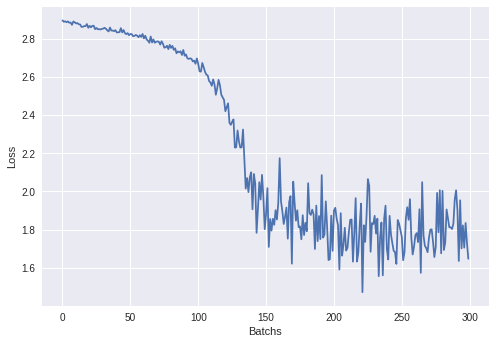

In [ ]:
net2 = LSTM_net(64, len(all_letters), len(nat))
train_setup(net2,'Adam',300,100,0.0001, 0.05)

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
#GRU

In [ ]:
class GRU_net(nn.Module):
  
  def __init__(self,hidden_size, input_size, output_size):
    super(GRU_net,self).__init__()
    self.hidden = hidden_size
    self.gru_cell = nn.GRU(input_size, hidden_size)
    self.i2o  = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)
  

  def forward(self, input_, hidden_):
    out_, hidden = self.gru_cell(input_.view(1,1,-1), hidden_)
    out  = self.i2o(hidden_)
    out = self.softmax(out)

    return out.view(1,-1), hidden_
  
  def init_hidden(self):
    return torch.zeros(1,1,self.hidden)


53000
Loss: 1.9771380424499512 Accuracy_test: 0.435 Accuracy_train: 0.463


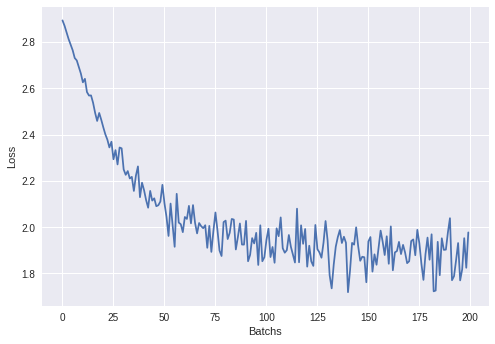

In [ ]:
net3 = GRU_net(128, len(all_letters), len(nat))
train_setup(net3 ,'sgd', 200, 265, 0.0005, 0.01)

In [ ]:
confusion_matrix[nat_rep('Russian')][nat_rep('Russian')] 

142679.0

Batching:

https://www.guvi.in/courses-video?course=dl_sequence_models#

to under_stand the rep matrix size below, we can refer 2:59 image in above video.

In [ ]:
def batched_name_rep(max_size, names): #Here, we are revcieving a batch of names!
  rep = torch.zeros(max_size,len(names),len(all_letters)) #This is a padded square matrix representation with, different names.
  for name_index, name in enumerate(names):
    for letter_index, letter in enumerate(name):
      pos = all_letters.find(letter)
      rep[letter_index][name_index][pos] = 1
  
  return rep

Visualise the character representation names in above function.

In [ ]:
def char_name(name_reps):
  names = name_reps.view((-1, name_reps.size()[-1])) #retain the last dimension, and collapse everything into single vector.
  for char in names:
    if torch.sum(char)==0:
      print("<pad>")
    else:
      char_arg = char.argmax()
      print(all_letters[char_arg])

In [ ]:
name_reps = batched_name_rep(6,['Akshit','jhon'])

In [ ]:

name_reps.shape

torch.Size([6, 2, 56])

In [ ]:
print(name_reps)
print(name_reps.shape)
char_name(name_reps)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
def batched_nat_rep(nats):
  rep = torch.zeros(len(nats),dtype=torch.long)
  for index, n in enumerate(nats):
    rep[index] = nat.index(n) 
  
  return rep

In [ ]:
print(batched_nat_rep(nat))

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17.])


Above, we did paddding. Padded instance is nothing but an all 0 tensor!

In [ ]:
def batched_dataloader(n_points, X_, Y_, verbos=False, device = 'cpu'):
  names = []                                    #List containing names.
  nat = []                                      #Containing corrosponding nationalities
  len_names = []                                # This is the length of names. The maximum name length is required while padding-packing. Thus done.
  
  for i in range(n_points):                     #Now, we iterate n_points:                             
    n = np.random.randint(len(X_))              #select a random index, for sampeling name.
    name, nat_  = X_[n], Y_[n]                  #selecting name
    names.append(name)
    nat.append(nat_)
    len_names.append(len(name))

  name_batched_rep = batched_name_rep(max(len_names),names).to(device) #Then, creating the batched, packed padded representation of names.
  nat_batched_rep = batched_nat_rep(nat).to(device)                    #Similarly nationality 

  padded_packed_name_rep = torch.nn.utils.rnn.pack_padded_sequence(name_batched_rep, len_names, enforce_sorted=False)#Packs a Tensor containing padded sequences of variable length. 
                                            #Padding and Packing of Inputs
  #Verbosing the data

  if verbos:
    print(len(names))
    print(name_batched_rep.shape,padded_packed_name_rep.data.shape)
    print('-------')

    print(names)
    print(char_name(name_batched_rep))
    print('-------')

    print("After Packing__________:")
    char_name(padded_packed_name_rep.data)
    print('nationality_representation', nat_batched_rep.int())
    print('Batch sizes', padded_packed_name_rep.batch_sizes)

  return padded_packed_name_rep.to(device), nat_batched_rep


In [ ]:
a, b = batched_dataloader(2,X_train,Y_train,False,'cuda:0')

In [ ]:
def train_batch(net, opt, loss_fn, n_points, device= 'cpu'):

  net = net.train().to(device)
  opt.zero_grad()
  
  train_batch, nat_true = batched_dataloader(n_points, X_train, Y_train, False, device)

  out_, hidden_ = net(train_batch)

  nat_true = nat_true.to(device)
  loss = loss_fn(out_, nat_true)

  loss.backward()
  opt.step()

  return loss


In [ ]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [ ]:
def get_val_batch(net, name, device = 'cpu'):
  
  name = name_rep(name).to(device)
  out, hidden = net.forward(name)

  if type(hidden) is tuple:
    hidden = hidden[0]
  
  index = torch.argmax(hidden)

  return out

In [ ]:
def evaluate_batch(net,n_points, X_, Y_,k=1, device = 'cpu'):

  net.eval().to(device)
  data = dataloader(n_points, X_, Y_)
  correct = 0
  
  for name, nat, name_rep, nat_rep in data:
  
    nat_rep = nat_rep.to(device)
    out = get_val_batch(net, name, 'cuda:0')
    values, ind = out.topk(k)
    ind = ind.to(device)

    if nat_rep in ind:
      correct+=1
  
  return correct/n_points



In [ ]:
# net  = RNN_net_1(len(all_letters),128, len(nat))
# loss_fn = nn.NLLLoss()
# opt = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.5)

In [ ]:
# train_setup(net,'sgd',100,25,0.005,0.1)

In [ ]:
def train_setup_batch(net,epochs=100,batch_size = 256,hidde_size=128, lr=0.1, m = 0.5, device='cpu'):
  
  
  loss_fn = nn.NLLLoss()
  opt = optim.SGD(net.parameters(), lr = lr, momentum = m)
  
  loss = []

  for i in tqdm_notebook(range(epochs), total = epochs, unit = 'epoch'):
    loss.append(train_batch(net, opt, loss_fn, batch_size, device))
  
  plt.figure(figsize=(10,5))
  plt.plot(loss,'-r')
  plt.xlabel('epochs')
  plt.show()

  return loss

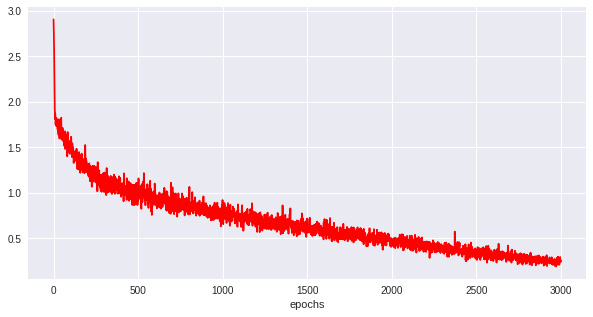

In [ ]:
epochs=3000
lr = 0.1
m=0.5 
hidden_size=128
batch_size = 512

net  = RNN_net(len(all_letters),hidden_size, len(nat))
loss_ = train_setup_batch(net,epochs, batch_size, hidden_size, lr, m, 'cuda:0')

In [ ]:
# net2 = LSTM_net(hidden_size, len(all_letters),len(nat))
# train_setup_batch(net2,epochs, batch_size, hidden_size, lr, m, 'cuda:0')

In [ ]:
evaluate_batch(len(X_test),X_test, Y_test, 1, 'cuda:0')

0.7614678899082569

In [ ]:
class LSTM_net_2(nn.Module):
  def __init__(self,hidden_size,input_size, output_size):
    super(LSTM_net_2,self).__init__()
    self.hidden = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.i2o  = nn.Linear(hidden_size, output_size)
    self.soft = nn.LogSoftmax(dim = 1)

  def forward(self, input_, hidden_=None):
    out_1, hidden = self.lstm_cell(input_, hidden_)           #Sending_input into hidden cel
    out_1 = self.i2o(hidden[0].view(-1, self.hidden))                           #Then, from lstm, we sent to hidden unit.
    out = self.soft(out_1)

    return out, hidden             
  
  def init_hidden(self, batch_size=1):
    return torch.zeros(1,batch_size,self.hidden), torch.zeros(1,batch_size,self.hidden)             #These are initial 2 hidden_layer and input layer.

In [ ]:
epochs=3000
lr = 0.1
m=0.5 
hidden_size=128
batch_size = 512

net2 = LSTM_net_2(hidden_size, len(all_letters),len(nat))
loss_ = train_setup_batch(net2,epochs, batch_size, hidden_size, lr, m, 'cuda:0')

In [ ]:
evaluate_batch(net2,len(X_test),X_test, Y_test, 1, 'cuda:0')

0.759872357399282